# Walk1D

This example demonstrates local stress testing in a 1D random walk environment.
- **System under test:** inactive; does nothing to control pawn movement or avoid failure.
- **Failure criterion:** pawn position exceeds critical value.
- **Stochastic disturbance:** 1-dimensional pawn movement, normally distributed.

In this case, the AST problem reduces to a simple goal-seeking reinforcement learning problem. This allows us to easily evaluate the efficacy of the solvers.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.develop(path="../..")
Pkg.instantiate()

  Activating project at `C:\Users\rlipkis\.julia\dev\adastress\examples\walk1d`
   Resolving package versions...
  No Changes to `C:\Users\rlipkis\.julia\dev\adastress\examples\walk1d\Project.toml`
  No Changes to `C:\Users\rlipkis\.julia\dev\adastress\examples\walk1d\Manifest.toml`


In [2]:
using Revise

In [3]:
using AdaStress
import AdaStress.BlackBox
using Plots

┌ Info: Precompiling AdaStress [f8632b6a-8763-4da0-bfaf-5f7707adef25]
└ @ Base loading.jl:1423


## Simulation

In [4]:
using Distributions
using Random

In [5]:
Base.@kwdef mutable struct Walk1D <: AdaStress.BlackBox
    t::Float64=0.0
    t_max::Float64=10.0
    x::Float64=0.0
    x_fail::Float64=10.0
    dist::Normal=Normal(0.0, 1.0)
    log::Vector{Float64} = []
end

function initialize!(sim::Walk1D)
    sim.t = 0.0
    sim.x = 0.0
    sim.log = [sim.x]
end

function update!(sim::Walk1D)
    sim.t += 1.0
    a = rand(sim.dist)
    sim.x += a
    push!(sim.log, sim.x)
    return logpdf(sim.dist, a) - logpdf(sim.dist, 0.0)
end

update! (generic function with 1 method)

In [6]:
AdaStress.reset!(sim::Walk1D) = initialize!(sim)
AdaStress.step!(sim::Walk1D) = update!(sim)
AdaStress.isterminal(sim::Walk1D) = sim.t >= sim.t_max
AdaStress.isevent(sim::Walk1D) = sim.x >= sim.x_fail
AdaStress.distance(sim::Walk1D) = max(sim.x_fail - sim.x, 0.0)

## MCS

In [7]:
mcs = AdaStress.Solvers.MCS(num_iterations=100_000)

AdaStress.Solvers.MonteCarloSearch.MCS(100000, 10)

In [8]:
mdp = AdaStress.ASTMDP(Walk1D())
mdp.reward.event_bonus = 100.0

100.0

In [9]:
Random.seed!(0)
@time sol = mcs(() -> mdp)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


  3.354207 seconds (32.08 M allocations: 1.296 GiB, 5.96% gc time, 42.19% compilation time)


DataStructures.PriorityQueue{Any, Any, Base.Order.ForwardOrdering} with 10 entries:
  MCSResult(UInt32[0xf5802e2c, 0xd83ebd70, 0xd15b1487, 0xc03e87cd, 0… => 101.884
  MCSResult(UInt32[0xf3da3b43, 0x1f21312a, 0xffe5a08d, 0xea132bbd, 0… => 101.888
  MCSResult(UInt32[0x8e5d795d, 0x60ff4448, 0x90f77fb9, 0x8c87dd2f, 0… => 101.989
  MCSResult(UInt32[0xae78d9ff, 0x8d2ae018, 0x24e648a6, 0x5e26f681, 0… => 102.045
  MCSResult(UInt32[0x05402236, 0xcc2396d7, 0xb2bfe4be, 0xc8ab9860, 0… => 102.355
  MCSResult(UInt32[0x2a8928e0, 0x12229ce7, 0x1b559438, 0xb4d5edfd, 0… => 102.52
  MCSResult(UInt32[0x0ee77df4, 0x20199fda, 0x091b74c1, 0x8a95e4a0, 0… => 102.537
  MCSResult(UInt32[0x7a0d1bdc, 0x3103f2f4, 0x76874476, 0xeee46c95, 0… => 102.696
  MCSResult(UInt32[0xf26e2a5e, 0x8c7abeb7, 0xd19875c7, 0xfb4919a2, 0… => 102.755
  MCSResult(UInt32[0xc61cf7f3, 0x47cb5356, 0x8949c52d, 0x2aacd1b6, 0… => 103.202

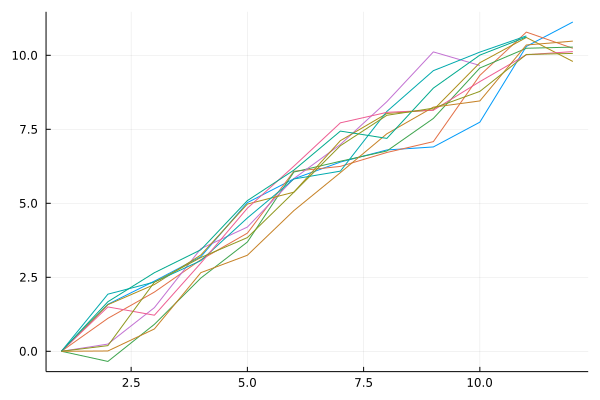

In [10]:
p = plot(legend=false)
for (result, r) in sol
    AdaStress.replay!(mdp, result)
    plot!(p, mdp.sim.log)
end
p

## MCTS

In [11]:
mcts = AdaStress.Solvers.MCTS(num_iterations=100_000)

AdaStress.Solvers.MonteCarloTreeSearch.MCTS(100000, 10, 1.0, 0.7, 1.0, nothing)

In [12]:
Random.seed!(0)
@time sol = mcts(() -> mdp)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


  2.318909 seconds (26.81 M allocations: 1.089 GiB, 7.89% gc time, 23.08% compilation time)


DataStructures.PriorityQueue{Any, Any, Base.Order.ForwardOrdering} with 10 entries:
  MCTSResult(UInt32[0x0f7c3082, 0xdd4d807c, 0x4036e445, 0xe86f4901, … => 102.011
  MCTSResult(UInt32[0x0f7c3082, 0xdd4d807c, 0x4036e445, 0xe86f4901, … => 102.036
  MCTSResult(UInt32[0x0f7c3082, 0xd59d38a8, 0xd792acb7, 0x653705ce, … => 102.042
  MCTSResult(UInt32[0x0f7c3082, 0xdd4d807c, 0x4036e445, 0xc0bdfdf4, … => 102.087
  MCTSResult(UInt32[0x0f7c3082, 0xdd4d807c, 0x4036e445, 0xe86f4901, … => 102.116
  MCTSResult(UInt32[0x0f7c3082, 0x091b74c1, 0x8a95e4a0, 0x55645832, … => 102.174
  MCTSResult(UInt32[0x0f7c3082, 0xdd4d807c, 0xd6685efb, 0x7cbf78c8, … => 102.332
  MCTSResult(UInt32[0x0f7c3082, 0x8f19bd96, 0xcb9ac7bd, 0x028888f4, … => 102.443
  MCTSResult(UInt32[0x0f7c3082, 0xdd4d807c, 0xab6e1d59, 0x096d9142, … => 102.957
  MCTSResult(UInt32[0x0f7c3082, 0xdd4d807c, 0x8c27a025, 0xafb8f5b1, … => 103.483

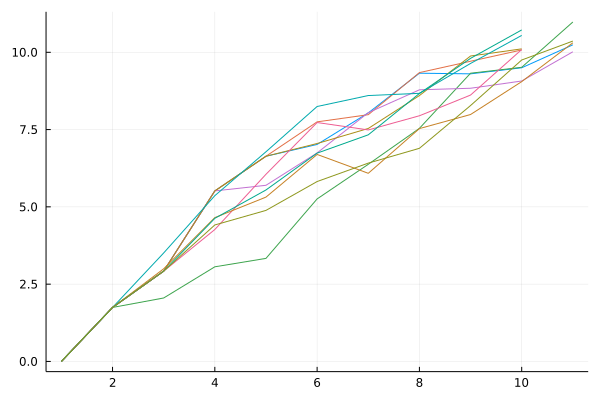

In [13]:
p = plot(legend=false)
for (result, r) in sol
    AdaStress.replay!(mdp, result)
    plot!(p, mdp.sim.log)
end
p